In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx

In [2]:
TRACE_FNAME = "../trace.out"

storage = defaultdict(lambda: {"r": set(), "w": set()})

with open(TRACE_FNAME, "r") as fp:
    for line in fp:
        if not line.startswith("#"):
            continue
        # print(line.strip()[2:-1].split(";"))
        mode, txn_idx, incarnation, key = line.strip()[2:-1].split(";")

        txn_idx = int(txn_idx)
        incarnation = int(incarnation)

        storage[(txn_idx, incarnation)][mode].add(key)

        print(mode, txn_idx, incarnation, key)


w 0 0 Basic(0x96f560d61c7247f8cb0a77cd2c0f9275aee5c7b5)
w 0 0 Basic(0x494cc492c9f01699bff1449180201dbfbd592ea5)
w 0 0 Basic(0xd67f7af73f88883f22b5a26e4edaaebdd1e4e517)
w 0 0 Basic(0x75481fdcd458522badb48e8b0d679174321b85e5)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x0000000000000000000000000000000000000000000000000000000000000009_U256)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x000000000000000000000000000000000000000000000000000000000000000a_U256)
w 0 0 Storage(0x75481fdcd458522badb48e8b0d679174321b85e5, 0x0000000000000000000000000000000000000000000000000000000000000008_U256)
w 0 0 Basic(0x53378825d95281737914a8a2ac0e5a9304ae5ed7)
w 0 0 Storage(0x53378825d95281737914a8a2ac0e5a9304ae5ed7, 0xaaec2ec6aeb37600054e89496d69898585866c92257d33b759f0a6a8af94d39f_U256)
w 0 0 Storage(0x53378825d95281737914a8a2ac0e5a9304ae5ed7, 0x0419b7a1ea2e83dc7ca47271dbf7a2918b30fe243b02c9d783ed908528209ee3_U256)
w 0 0 Basic(0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2)
w 0 0 Sto

In [3]:
incarnations = defaultdict(lambda: 0)
for (txn_idx, incarnation) in storage:
    incarnations[txn_idx] = max(incarnation, incarnations[txn_idx])

In [4]:
for (txn_idx, incarnation) in incarnations.items():
    print(txn_idx, incarnation)

0 0
3 0
6 0
4 0
8 0
7 0
10 0
11 0
12 1
14 1
9 0
1 1
17 0
15 1
19 0
20 1
21 0
22 0
16 1
23 1
2 1
24 1
5 1
26 1
13 1
34 0
35 0
36 0
18 1
38 0
39 0
25 1
27 1
28 2
29 1
30 2
31 1
32 2
33 1
37 1
40 0
43 0
41 0
44 1
45 1
42 1
46 1
47 7
48 3
49 8
52 1
50 24
51 4
62 0
58 1
53 2
65 0
64 1
66 0
54 1
67 0
55 2
68 1
56 2
57 2
59 1
60 1
61 2
63 2
69 0
71 0
76 0
72 1
79 0
80 0
73 1
74 1
75 1
85 0
86 0
87 0
88 0
90 0
91 0
77 1
92 0
94 0
70 1
82 1
98 0
83 1
78 1
84 1
93 1
95 1
101 2
104 1
96 1
81 1
99 3
97 1
89 1
102 2
110 0
100 3
105 2
111 1
112 1
114 0
113 1
103 2
118 0
119 0
117 0
108 1
115 1
120 0
122 0
124 0
116 1
106 2
126 1
127 0
123 0
121 1
107 3
125 3
128 0
109 6
131 0
133 0
134 1
139 0
141 0
137 1
136 3
144 1
138 5
142 2
129 1
135 1
143 2
148 0
146 1
151 0
145 2
147 2
150 1
154 1
156 0
157 0
158 0
153 1
161 0
159 0
155 1
160 1
163 0
162 0
164 0
130 1
132 1
165 3
140 1
149 1
152 1
167 0
166 0
172 0
174 0
175 0
168 0
176 0
178 0
179 0
170 0
182 0
181 0
183 0
171 0
169 0
184 0
173 1
187 0
180 0

In [17]:
all_txn_incarnations = list(sorted(incarnations.items()))

graph = nx.DiGraph()

def to_key(txn_idx, incarnation):
    return f"{txn_idx}-{incarnation}"

graph.add_nodes_from([to_key(txn_idx, incarnation) for (txn_idx, incarnation) in all_txn_incarnations])

for i, (txn_idx, incarnation) in enumerate(all_txn_incarnations):
    # print(txn_idx, incarnation, len(storage[(txn_idx, incarnation)]["r"]), len(storage[(txn_idx, incarnation)]["w"]))
    outer_read_set = storage[(txn_idx, incarnation)]["r"]
    outer_write_set = storage[(txn_idx, incarnation)]["w"]
    for (inner_txn_idx, inner_incarnation) in all_txn_incarnations[i+1:]:
        inner_read_set = storage[(inner_txn_idx, inner_incarnation)]["r"]
        inner_write_set = storage[(inner_txn_idx, inner_incarnation)]["w"]
        if len(inner_read_set.intersection(outer_write_set)) > 0:
            print(f"Read-write conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))
        elif len(inner_write_set.intersection(outer_read_set)) > 0:
            print(f"Write-after-read conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))
        elif len(inner_write_set.intersection(outer_write_set)) > 0:
            print(f"Write-after-write conflict detected between txn {txn_idx} and {inner_txn_idx}")
            graph.add_edge(to_key(txn_idx, incarnation), to_key(inner_txn_idx, inner_incarnation))

Read-write conflict detected between txn 0 and 1
Read-write conflict detected between txn 0 and 2
Read-write conflict detected between txn 0 and 5
Read-write conflict detected between txn 0 and 18
Read-write conflict detected between txn 0 and 25
Read-write conflict detected between txn 0 and 27
Read-write conflict detected between txn 0 and 29
Read-write conflict detected between txn 0 and 30
Read-write conflict detected between txn 0 and 32
Read-write conflict detected between txn 0 and 33
Read-write conflict detected between txn 0 and 52
Read-write conflict detected between txn 0 and 58
Read-write conflict detected between txn 0 and 71
Read-write conflict detected between txn 0 and 72
Read-write conflict detected between txn 0 and 73
Read-write conflict detected between txn 0 and 74
Read-write conflict detected between txn 0 and 75
Read-write conflict detected between txn 0 and 81
Read-write conflict detected between txn 0 and 89
Read-write conflict detected between txn 0 and 108
Re

In [18]:
str(graph)

'DiGraph with 211 nodes and 1593 edges'

In [19]:
# print height of graph
print("Graph depth:", nx.dag_longest_path_length(graph))
print("Maximum speedup under infinite parallelism:", len(all_txn_incarnations) / nx.dag_longest_path_length(graph))

Graph depth: 52
Maximum speedup under infinite parallelism: 4.0576923076923075


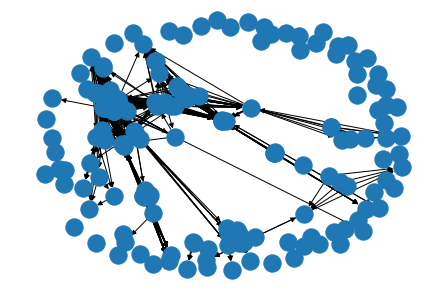

In [20]:
nx.draw(graph)

In [21]:
nx.write_adjlist(graph, "graph.adjlist")

In [22]:
repr(graph.nodes())

"NodeView(('0-0', '1-1', '2-1', '3-0', '4-0', '5-1', '6-0', '7-0', '8-0', '9-0', '10-0', '11-0', '12-1', '13-1', '14-1', '15-1', '16-1', '17-0', '18-1', '19-0', '20-1', '21-0', '22-0', '23-1', '24-1', '25-1', '26-1', '27-1', '28-2', '29-1', '30-2', '31-1', '32-2', '33-1', '34-0', '35-0', '36-0', '37-1', '38-0', '39-0', '40-0', '41-0', '42-1', '43-0', '44-1', '45-1', '46-1', '47-7', '48-3', '49-8', '50-24', '51-4', '52-1', '53-2', '54-1', '55-2', '56-2', '57-2', '58-1', '59-1', '60-1', '61-2', '62-0', '63-2', '64-1', '65-0', '66-0', '67-0', '68-1', '69-0', '70-1', '71-0', '72-1', '73-1', '74-1', '75-1', '76-0', '77-1', '78-1', '79-0', '80-0', '81-1', '82-1', '83-1', '84-1', '85-0', '86-0', '87-0', '88-0', '89-1', '90-0', '91-0', '92-0', '93-1', '94-0', '95-1', '96-1', '97-1', '98-0', '99-3', '100-3', '101-2', '102-2', '103-2', '104-1', '105-2', '106-2', '107-3', '108-1', '109-6', '110-0', '111-1', '112-1', '113-1', '114-0', '115-1', '116-1', '117-0', '118-0', '119-0', '120-0', '121-1', 

In [24]:
nx.read_adjlist("graph.adjlist").nodes()

NodeView(('0-0', '1-1', '2-1', '5-1', '18-1', '25-1', '27-1', '29-1', '30-2', '32-2', '33-1', '52-1', '58-1', '71-0', '72-1', '73-1', '74-1', '75-1', '81-1', '89-1', '108-1', '129-1', '130-1', '132-1', '140-1', '149-1', '152-1', '165-3', '166-0', '197-1', '198-1', '202-1', '203-1', '13-1', '37-1', '40-0', '76-0', '77-1', '78-1', '3-0', '4-0', '22-0', '23-1', '24-1', '26-1', '43-0', '45-1', '46-1', '47-7', '48-3', '49-8', '50-24', '51-4', '53-2', '54-1', '55-2', '56-2', '59-1', '60-1', '61-2', '63-2', '70-1', '82-1', '83-1', '84-1', '93-1', '96-1', '100-3', '102-2', '105-2', '106-2', '107-3', '135-1', '182-0', '6-0', '159-0', '191-0', '7-0', '8-0', '67-0', '69-0', '177-1', '9-0', '10-0', '15-1', '16-1', '28-2', '41-0', '42-1', '66-0', '80-0', '110-0', '111-1', '115-1', '116-1', '186-1', '190-1', '11-0', '12-1', '14-1', '17-0', '19-0', '20-1', '21-0', '31-1', '57-2', '162-0', '199-1', '200-1', '201-1', '34-0', '35-0', '36-0', '38-0', '39-0', '44-1', '193-0', '62-0', '64-1', '65-0', '68-1

In [25]:
sample_graph = nx.DiGraph()
sample_graph.add_nodes_from([0, 1, 2, 3, 4])
sample_graph.add_edge(0, 2)
sample_graph.add_edge(2, 3)
sample_graph.add_edge(3, 4)
sample_graph.add_edge(1, 3)

In [26]:
list(nx.topological_generations(sample_graph))

[[0, 1], [2], [3], [4]]

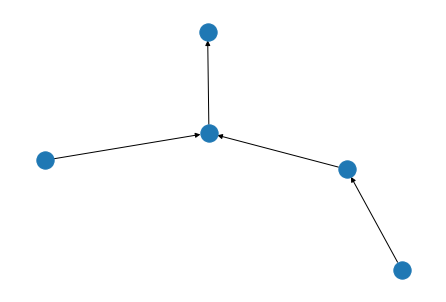

In [27]:
nx.draw(sample_graph)